# Ensemble MH

In [1]:
import matplotlib.pyplot as plt
from mcmc import *
from mcmc_ensemble import *
from mcmc_plots import *
%load_ext autoreload
%autoreload 2

In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

plt.rcParams['patch.edgecolor'] = 'black'

In [3]:
DATA_PATH = "../GRBs/GRB_data.txt"
arr = np.loadtxt(DATA_PATH, skiprows=1)
logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

## Generated Data - sigma_logT90 = 0

In [59]:
LOAD = 0
outdir = '../figure/generated_data'

rng = np.random.default_rng(1234)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

theta_true = {"w": 0.3, "mu1": -0.5, "mu2": 3.5, "sigma1": 0.8, "sigma2": 1.0}
logT90 = generate_data(theta_true, N = len(logT90), rng=rng, sigma_logT90=sigma_logT90)

theta_sim = np.array((theta_true['w'], 
                    theta_true['mu1'], 
                    theta_true['mu2']-theta_true['mu1'], 
                    np.log(theta_true['sigma1']),
                    np.log(theta_true['sigma2']))) 

print('logL (simulation)= ', log_likelihood(logT90, theta_sim, sigma_logT90))

# define the prior bounds
bounds = [
    [0.0, 1.0],     # w
    [-4, 7],        # mu1 (ln s)
    [0.0, 10.0],    # delta = mu2 - mu1
    [np.log(0.1), np.log(6.0)],    # ln(sigma1) 
    [np.log(0.1), np.log(6.0)]     # ln(sigma2)
]

if LOAD == 0:
    theta_center = init_theta_from_data(logT90, bounds)  
    
    # la cov stimata 
    covariance = np.array(
        ([ 1.10699367e-04,  7.98001466e-05, -1.65689048e-05,  4.40845573e-05, -4.28138283e-05],
         [ 7.98001466e-05,  1.14011773e-03, -8.92977095e-04,  3.62863563e-04, -1.44984942e-04],
         [-1.65689048e-05, -8.92977095e-04,  1.48099232e-03, -6.08273098e-05, -3.02914339e-05],
         [ 4.40845573e-05,  3.62863563e-04, -6.08273098e-05,  1.41933661e-03, -2.51210812e-04],
         [-4.28138283e-05, -1.44984942e-04, -3.02914339e-05, -2.51210812e-04, 5.78657424e-04])) 
    
    res = run_ensemble_chains(theta_center, logT90, bounds, rng=rng,
                              n_chains=8, n_steps=50000, cov_prop=covariance,
                              sigma_logT90=0.0, scale=0.1, verbose=True)
    
    # access:
    theta0s = res['theta0s']      # shape (8,5)
    chains  = res['chains']       # list of 8 arrays (n_steps,5)
    chains  = np.stack(chains)    # array 3D (n_chains,n_steps,5)
    accs    = res['acc_rates']    # list of 8 empirical acceptance rates

    np.savez_compressed("../chains/chains_stack_10.npz", chains=chains, theta0s=theta0s, acc_rates=accs)
    
else:
    data = np.load("../chains/chains_stack_10.npz")
    theta0s = data['theta0s']      # shape (8,5)
    chains  = data['chains']       # array 3D (n_chains,n_steps,5)
    accs    = data['acc_rates']

logL (simulation)=  -3730.0687128964673
Starting chain 1/8, theta0 = [ 0.61424637  0.55443885  4.45111348 -0.13819681  0.31522879]
iteration 0: acceptance 1.0
iteration 2500: acceptance 0.3598560575769692
iteration 5000: acceptance 0.35032993401319734
iteration 7500: acceptance 0.3346220503932809
iteration 10000: acceptance 0.3354664533546645
iteration 12500: acceptance 0.33405327573794097
iteration 15000: acceptance 0.33264449036730886
iteration 17500: acceptance 0.32940974801439915
iteration 20000: acceptance 0.3289835508224589
iteration 22500: acceptance 0.32754099817785876
iteration 25000: acceptance 0.3261069557217711
iteration 27500: acceptance 0.32562452274462744
iteration 30000: acceptance 0.325155828139062
iteration 32500: acceptance 0.3242361773483893
iteration 35000: acceptance 0.32590497414359587
iteration 37500: acceptance 0.32513799632009815
iteration 40000: acceptance 0.32541686457838553
iteration 42500: acceptance 0.32705112820874804
iteration 45000: acceptance 0.325792

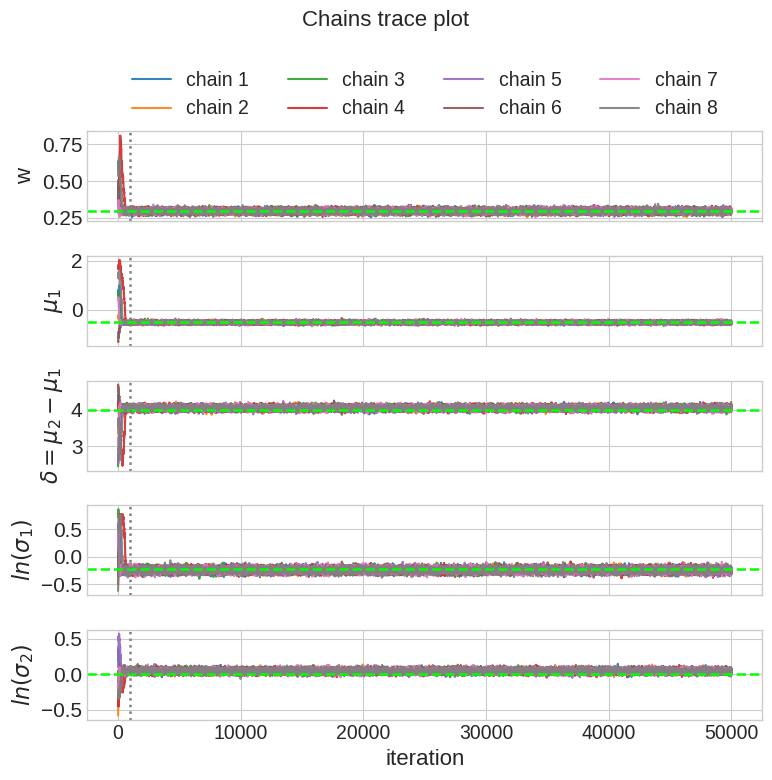

In [60]:
# scale 15% -> burnin = 9000
# scale 10% -> burnin = 1000
filename = "ensemble_trace_plot_10"
fig, axes = plot_trace_chains(chains, filename, theta_sim, burnin=1000, save=True, outdir=outdir)
plt.show()

In [61]:
burnin = 1000
chains_new = chains[:,1000:,:]
chains_new.shape

(8, 49000, 5)

La threshold viene scelta guardando a quale valore di autocorrelazione corrisponde al parametro più lento (autocorrelazione più alta) a lag 25 (valore scelto nella mcmc con singola catena nelle condizioni di dati generati e logT90 = 0)

In [62]:
thinned_list, per_param_lags, per_chain_lags = thin_chains_by_acf(
    chains_new, threshold=0.1, max_lag_search=2000
)

# lags in cui acf < threshold per ogni parametro e ogni catena
print("per-param lags:\n", per_param_lags)
# per ogni catena scelgo il parametro con il lag maggiore
print("per-chain steps:", per_chain_lags)

per-param lags:
 [[20 24 25 17 18]
 [19 20 22 17 17]
 [21 23 23 19 19]
 [22 21 22 17 18]
 [21 23 22 17 16]
 [20 21 23 17 16]
 [21 25 26 19 18]
 [20 24 23 18 20]]
per-chain steps: [25 22 23 22 23 23 26 24]


In [63]:
for i in range(chains_new.shape[0]):
    print(f'chain {i+1} shape = {thinned_list[i].shape}')

chain 1 shape = (1960, 5)
chain 2 shape = (2228, 5)
chain 3 shape = (2131, 5)
chain 4 shape = (2228, 5)
chain 5 shape = (2131, 5)
chain 6 shape = (2131, 5)
chain 7 shape = (1885, 5)
chain 8 shape = (2042, 5)


Visto che dopo il thinning i valri sono indipendenti tra loro posso concatenare le 8 catene

In [64]:
# thinned_chains_list: lista di array (n_kept_k, d) — output della tua funzione
samples_final = np.concatenate([c for c in thinned_list], axis=0)  # shape (N_total, d)
samples_final.shape

(16736, 5)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:297: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0.06)
/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(pdf_path, dpi=300, bbox_inches='tight', pad_inches=0.06)


Saved: ../figure/generated_data/marginal_distribution_mcmc_ensemble.png (PNG 300 dpi) and ../figure/generated_data/marginal_distribution_mcmc_ensemble.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


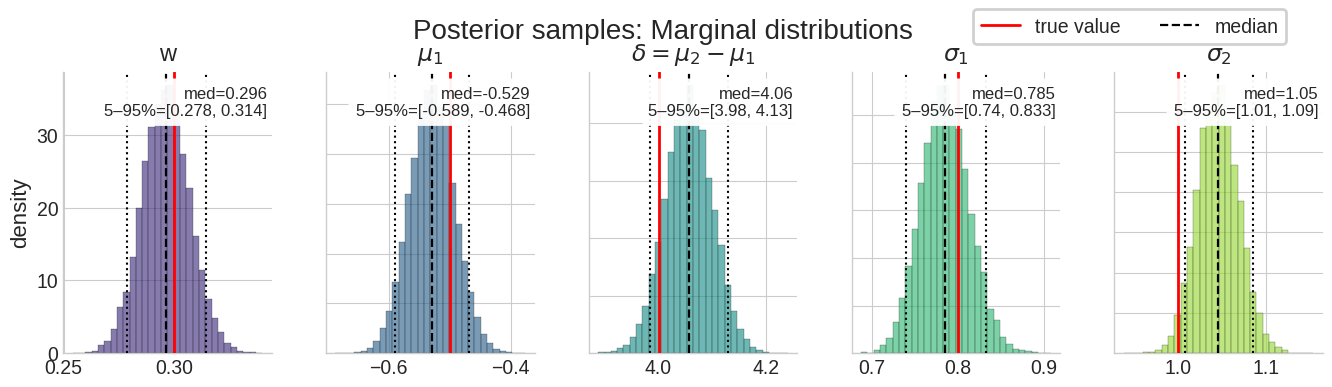

In [65]:
filename = 'marginal_distribution_mcmc_ensemble'
fig2, axes2 = plot_marginal_distributions(samples_final, filename, theta_sim, sigma_scale='linear', outdir=outdir)

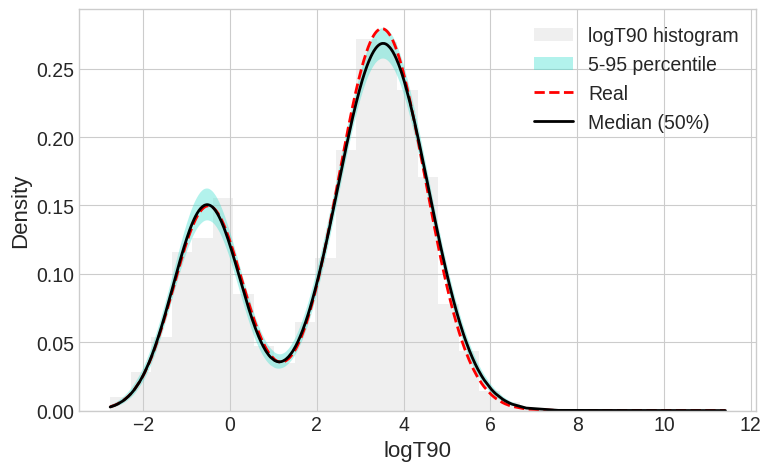

In [66]:
filename = 'distribution_mcmc_ensemble'
fig4, axes4 = plot_distribution(logT90, samples_final, filename, theta_true=theta_sim, outdir=outdir)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:750: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


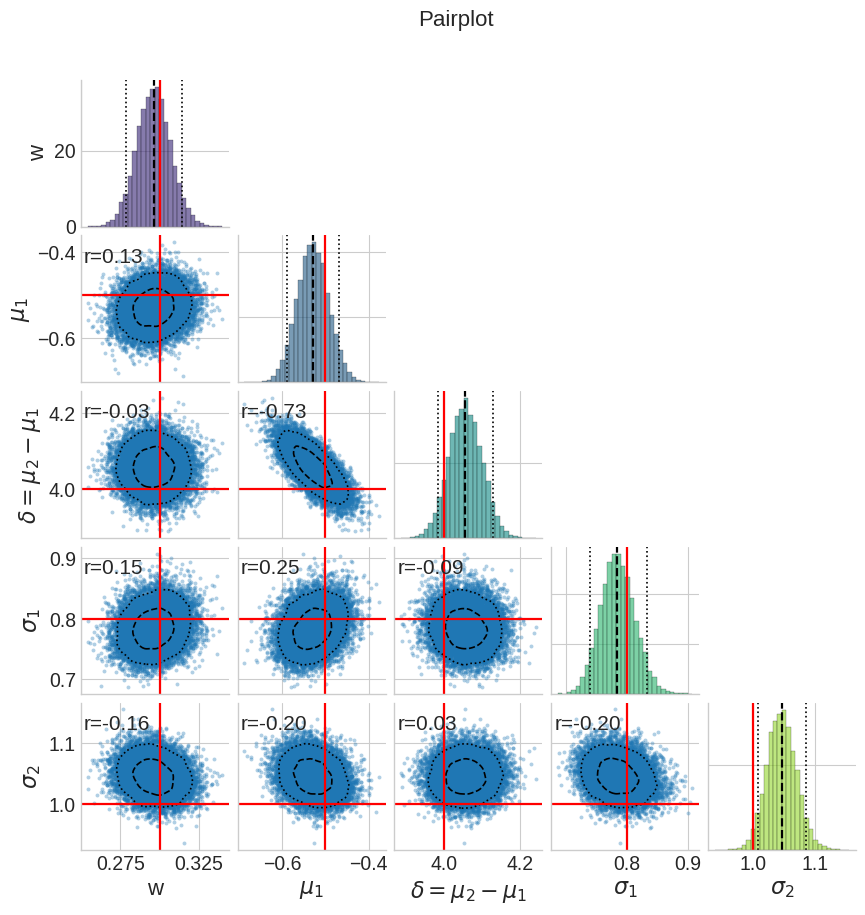

In [67]:
filename = 'Pairplot_ensemble'
fig5, axes5 = pairplot(samples_final, filename, theta_sim, save=True, sigma_scale='linear', outdir=outdir)

In [68]:
# trasformazione
sigma1_samples = np.exp(samples_final[:,3])
sigma2_samples = np.exp(samples_final[:,4])

samples_transformed = samples_final.copy()
samples_transformed[:,3] = sigma1_samples
samples_transformed[:,4] = sigma2_samples

In [69]:
lns1, lns2 = samples_final[:,3:].T
w, mu1, delta, s1, s2 = samples_transformed.T
mu2 = mu1 + delta

scale1 = np.exp(mu1)
scale2 = np.exp(mu2)
mean1 = np.exp(mu1 + 0.5 * s1**2)
mean2 = np.exp(mu2 + 0.5 * s2**2)
sd1 = np.sqrt((np.exp(s1**2)-1) * np.exp(2*mu1 + s1**2))
sd2 = np.sqrt((np.exp(s2**2)-1) * np.exp(2*mu2 + s2**2))

def pctls(a):
    p = np.percentile(a, [5,16,50,84,95])
    mean  = np.mean(a)
    sigma = np.std(a, ddof=1)
    # median, +err, -err, +err90, -err90, sigma, mean
    return p[2], p[3]-p[2], p[2]-p[1], p[4]-p[2], p[2]-p[0], sigma, mean  

print("Parametri mcmc:")
for name, param in [('w',w),('mu1',mu1),('delta',delta),('mu2',mu2),
                    ('lns1', lns1),('lns2', lns2),('s1',s1),('s2',s2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f}  ({mean:.3f}±{sigma:.3f})    [{med-down90:.3f}, {med+up90:.3f}]  (90%)")

print("\nParametri in secondi:")
for name, param in [('median1',scale1),('median2',scale2),('mean1',mean1),('mean2',mean2),('sd1',sd1),('sd2',sd2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f} s  ({mean:.3f}±{sigma:.3f})   [{med-down90:.3f}, {med+up90:.3f}] s (90%)")

Parametri mcmc:
w: 0.296 +0.011 -0.011  (0.296±0.011)    [0.278, 0.314]  (90%)
mu1: -0.529 +0.037 -0.037  (-0.529±0.037)    [-0.589, -0.468]  (90%)
delta: 4.056 +0.045 -0.043  (4.056±0.044)    [3.984, 4.128]  (90%)
mu2: 3.528 +0.031 -0.031  (3.527±0.031)    [3.477, 3.578]  (90%)
lns1: -0.242 +0.036 -0.035  (-0.242±0.036)    [-0.301, -0.183]  (90%)
lns2: 0.044 +0.023 -0.022  (0.044±0.023)    [0.008, 0.082]  (90%)
s1: 0.785 +0.029 -0.027  (0.786±0.028)    [0.740, 0.833]  (90%)
s2: 1.045 +0.024 -0.023  (1.046±0.024)    [1.008, 1.085]  (90%)

Parametri in secondi:
median1: 0.589 +0.022 -0.021 s  (0.590±0.022)   [0.555, 0.626] s (90%)
median2: 34.039 +1.060 -1.033 s  (34.049±1.048)   [32.351, 35.799] s (90%)
mean1: 0.802 +0.040 -0.036 s  (0.803±0.038)   [0.743, 0.869] s (90%)
mean2: 58.800 +2.115 -2.057 s  (58.850±2.093)   [55.542, 62.405] s (90%)
sd1: 0.740 +0.068 -0.060 s  (0.744±0.066)   [0.645, 0.858] s (90%)
sd2: 82.750 +5.486 -4.975 s  (83.018±5.310)   [74.816, 92.238] s (90%)


## Real Data - sigma_logT90 = 0

In [71]:
LOAD = 0
outdir = '../figure/real_data'

rng = np.random.default_rng(1234)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

# define the prior bounds
bounds = [
    [0.0, 1.0],     # w
    [-4, 7],        # mu1 (ln s)
    [0.0, 10.0],    # delta = mu2 - mu1
    [np.log(0.1), np.log(6.0)],    # ln(sigma1) 
    [np.log(0.1), np.log(6.0)]     # ln(sigma2)
]

if LOAD == 0:
    theta_center = init_theta_from_data(logT90, bounds)  
    
    # la cov stimata 
    covariance = np.array(
        ([ 0.00036691,  0.00168623, -0.00117116,  0.00076398, -0.00033632],
         [ 0.00168623,  0.01478118, -0.01111397,  0.0049843,  -0.00238093],
         [-0.00117116, -0.01111397,  0.00920665, -0.0035476,   0.00156858],
         [ 0.00076398,  0.0049843,  -0.0035476,   0.00329768, -0.00094723],
         [-0.00033632, -0.00238093,  0.00156858, -0.00094723,  0.00096989]))
    
    res = run_ensemble_chains(theta_center, logT90, bounds, rng=rng,
                              n_chains=8, n_steps=50000, cov_prop=covariance,
                              sigma_logT90=0.0, scale=0.1, verbose=True)
    
    # access:
    theta0s = res['theta0s']      # shape (8,5)
    chains  = res['chains']       # list of 8 arrays (n_steps,5)
    chains  = np.stack(chains)    # array 3D (n_chains,n_steps,5)
    accs    = res['acc_rates']    # list of 8 empirical acceptance rates

    np.savez_compressed("../chains/chains_stack_real_10.npz", chains=chains, theta0s=theta0s, acc_rates=accs)
    
else:
    data = np.load("../chains/chains_stack_real_10.npz")
    theta0s = data['theta0s']      # shape (8,5)
    chains  = data['chains']       # array 3D (n_chains,n_steps,5)
    accs    = data['acc_rates']

Starting chain 1/8, theta0 = [0.33961632 1.03520978 3.6822768  0.06248756 0.35364651]
iteration 0: acceptance 0.0
iteration 2500: acceptance 0.3246701319472211
iteration 5000: acceptance 0.3157368526294741
iteration 7500: acceptance 0.3247566991067858
iteration 10000: acceptance 0.32466753324667535
iteration 12500: acceptance 0.32853371730261577
iteration 15000: acceptance 0.32764482367842146
iteration 17500: acceptance 0.3262099308610937
iteration 20000: acceptance 0.32518374081295937
iteration 22500: acceptance 0.3246522376783254
iteration 25000: acceptance 0.3250669973201072
iteration 27500: acceptance 0.3244972910075997
iteration 30000: acceptance 0.32458918036065465
iteration 32500: acceptance 0.32337466539491094
iteration 35000: acceptance 0.3236193251621382
iteration 37500: acceptance 0.3243380176528626
iteration 40000: acceptance 0.3237169070773231
iteration 42500: acceptance 0.3236865014940825
iteration 45000: acceptance 0.32457056509855337
iteration 47500: acceptance 0.324245

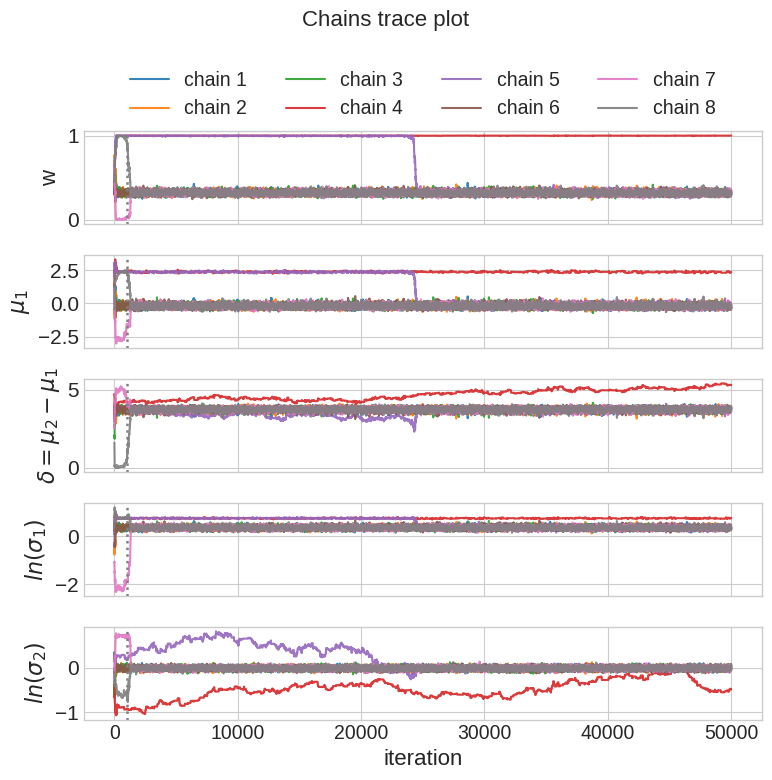

In [72]:
filename = "ensemble_trace_plot_real_10"
fig, axes = plot_trace_chains(chains, filename, burnin=1000, save=True, outdir=outdir)
plt.show()

In [73]:
# Taglio le catene 4 e 5
chains_cut = chains.copy()
chains_cut = np.delete(chains_cut, [3,4], axis=0)
chains_cut.shape

(6, 50000, 5)

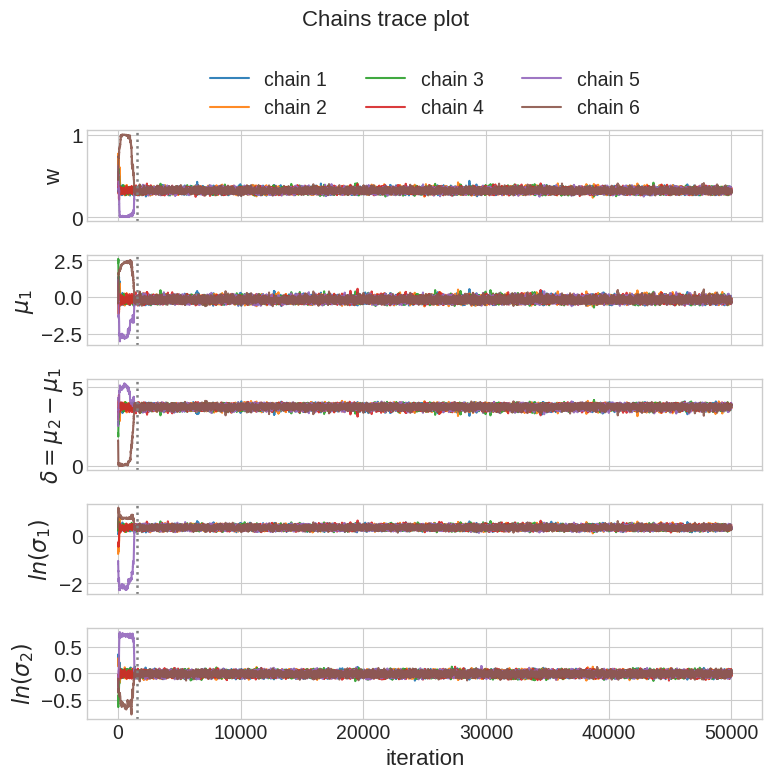

In [76]:
filename = "ensemble_trace_plot_real_10_cut"
fig, axes = plot_trace_chains(chains_cut, filename, burnin=1500, save=True, outdir=outdir)
plt.show()

In [77]:
burnin = 1500
chains_new = chains_cut[:,burnin:,:]
chains_new.shape

(6, 48500, 5)

La threshold viene scelta guardando a quale valore di autocorrelazione corrisponde al parametro più lento (autocorrelazione più alta) a lag 25 (valore scelto nella mcmc con singola catena nelle condizioni di dati generati e logT90 = 0)

In [78]:
thinned_list, per_param_lags, per_chain_lags = thin_chains_by_acf(
    chains_new, threshold=0.1, max_lag_search=2000
)

# lags in cui acf < threshold per ogni parametro e ogni catena
print("per-param lags:\n", per_param_lags)
# per ogni catena scelgo il parametro con il lag maggiore
print("per-chain steps:", per_chain_lags)

per-param lags:
 [[22 26 26 22 22]
 [22 25 25 23 21]
 [22 23 24 24 21]
 [19 22 23 19 19]
 [23 25 24 21 21]
 [23 23 23 22 21]]
per-chain steps: [26 25 24 23 25 23]


In [79]:
for i in range(chains_new.shape[0]):
    print(f'chain {i+1} shape = {thinned_list[i].shape}')

chain 1 shape = (1866, 5)
chain 2 shape = (1940, 5)
chain 3 shape = (2021, 5)
chain 4 shape = (2109, 5)
chain 5 shape = (1940, 5)
chain 6 shape = (2109, 5)


Visto che dopo il thinning i valri sono indipendenti tra loro posso concatenare le 8 catene

In [80]:
# thinned_chains_list: lista di array (n_kept_k, d) — output della tua funzione
samples_final = np.concatenate([c for c in thinned_list], axis=0)  # shape (N_total, d)
samples_final.shape

(11985, 5)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:297: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0.06)
/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(pdf_path, dpi=300, bbox_inches='tight', pad_inches=0.06)


Saved: ../figure/real_data/marginal_distribution_mcmc_ensemble_real.png (PNG 300 dpi) and ../figure/real_data/marginal_distribution_mcmc_ensemble_real.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


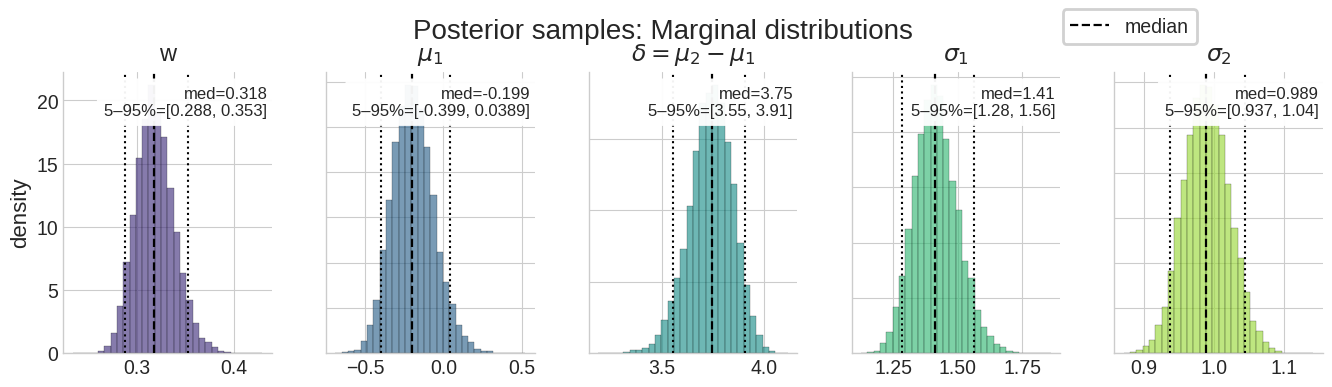

In [81]:
filename = 'marginal_distribution_mcmc_ensemble_real'
fig2, axes2 = plot_marginal_distributions(samples_final, filename, sigma_scale='linear', outdir=outdir)

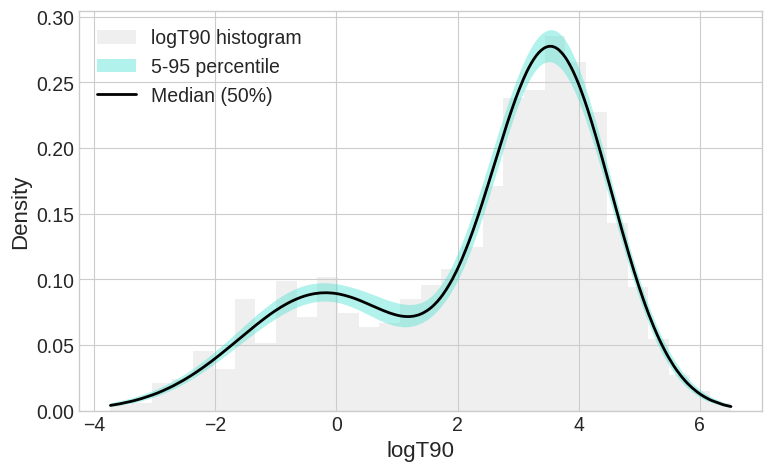

In [82]:
filename = 'distribution_mcmc_ensemble_real'
fig4, axes4 = plot_distribution(logT90, samples_final, filename, outdir=outdir)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:750: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


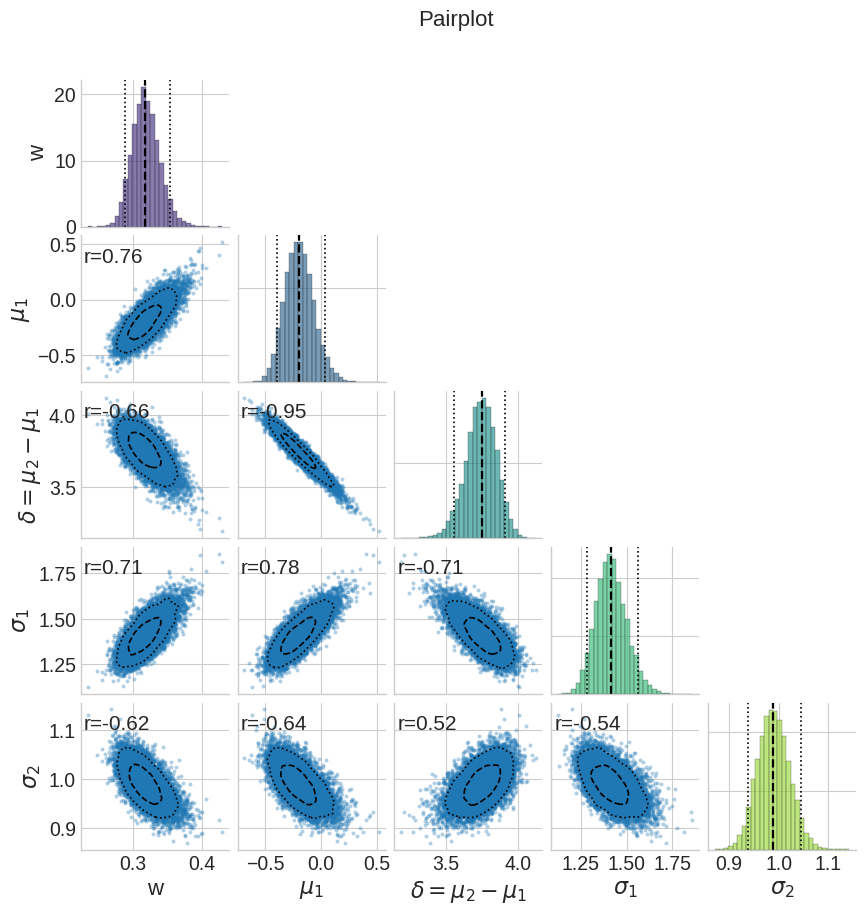

In [86]:
filename = 'Pairplot_ensemble_real'
fig5, axes5 = pairplot(samples_final, filename, save=True, sigma_scale='linear', outdir=outdir)

In [84]:
# trasformazione
sigma1_samples = np.exp(samples_final[:,3])
sigma2_samples = np.exp(samples_final[:,4])

samples_transformed = samples_final.copy()
samples_transformed[:,3] = sigma1_samples
samples_transformed[:,4] = sigma2_samples

In [85]:
lns1, lns2 = samples_final[:,3:].T
w, mu1, delta, s1, s2 = samples_transformed.T
mu2 = mu1 + delta

scale1 = np.exp(mu1)
scale2 = np.exp(mu2)
mean1 = np.exp(mu1 + 0.5 * s1**2)
mean2 = np.exp(mu2 + 0.5 * s2**2)
sd1 = np.sqrt((np.exp(s1**2)-1) * np.exp(2*mu1 + s1**2))
sd2 = np.sqrt((np.exp(s2**2)-1) * np.exp(2*mu2 + s2**2))

def pctls(a):
    p = np.percentile(a, [5,16,50,84,95])
    mean  = np.mean(a)
    sigma = np.std(a, ddof=1)
    # median, +err, -err, +err90, -err90, sigma, mean
    return p[2], p[3]-p[2], p[2]-p[1], p[4]-p[2], p[2]-p[0], sigma, mean  

print("Parametri mcmc:")
for name, param in [('w',w),('mu1',mu1),('delta',delta),('mu2',mu2),
                    ('lns1', lns1),('lns2', lns2),('s1',s1),('s2',s2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f}  ({mean:.3f}±{sigma:.3f})    [{med-down90:.3f}, {med+up90:.3f}]  (90%)")

print("\nParametri in secondi:")
for name, param in [('median1',scale1),('median2',scale2),('mean1',mean1),('mean2',mean2),('sd1',sd1),('sd2',sd2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f} s  ({mean:.3f}±{sigma:.3f})   [{med-down90:.3f}, {med+up90:.3f}] s (90%)")

Parametri mcmc:
w: 0.318 +0.021 -0.019  (0.319±0.020)    [0.288, 0.353]  (90%)
mu1: -0.199 +0.135 -0.126  (-0.193±0.134)    [-0.399, 0.039]  (90%)
delta: 3.746 +0.102 -0.108  (3.741±0.107)    [3.555, 3.908]  (90%)
mu2: 3.548 +0.046 -0.045  (3.548±0.046)    [3.471, 3.623]  (90%)
lns1: 0.345 +0.060 -0.058  (0.346±0.060)    [0.249, 0.446]  (90%)
lns2: -0.011 +0.033 -0.033  (-0.011±0.033)    [-0.065, 0.043]  (90%)
s1: 1.412 +0.088 -0.080  (1.416±0.085)    [1.283, 1.562]  (90%)
s2: 0.989 +0.033 -0.032  (0.990±0.033)    [0.937, 1.044]  (90%)

Parametri in secondi:
median1: 0.819 +0.118 -0.097 s  (0.832±0.115)   [0.671, 1.040] s (90%)
median2: 34.727 +1.620 -1.536 s  (34.767±1.598)   [32.164, 37.453] s (90%)
mean1: 2.216 +0.628 -0.433 s  (2.323±0.605)   [1.564, 3.429] s (90%)
mean2: 56.704 +2.030 -1.962 s  (56.741±2.031)   [53.457, 60.162] s (90%)
sd1: 5.574 +2.679 -1.616 s  (6.165±2.671)   [3.223, 11.005] s (90%)
sd2: 72.948 +5.131 -4.391 s  (73.268±4.845)   [65.902, 81.763] s (90%)


## Generated Data - sigma_logT90

In [48]:
LOAD = 0
outdir = '../figure/generated_data_sigmaT90'

rng = np.random.default_rng(1234)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

theta_true = {"w": 0.3, "mu1": -0.5, "mu2": 3.5, "sigma1": 0.8, "sigma2": 1.0}
logT90 = generate_data(theta_true, N = len(logT90), rng=rng, sigma_logT90=sigma_logT90)

theta_sim = np.array((theta_true['w'], 
                    theta_true['mu1'], 
                    theta_true['mu2']-theta_true['mu1'], 
                    np.log(theta_true['sigma1']),
                    np.log(theta_true['sigma2']))) 

print('logL (simulation)= ', log_likelihood(logT90, theta_sim, sigma_logT90))

# define the prior bounds
bounds = [
    [0.0, 1.0],     # w
    [-4, 7],        # mu1 (ln s)
    [0.0, 10.0],    # delta = mu2 - mu1
    [np.log(0.1), np.log(6.0)],    # ln(sigma1) 
    [np.log(0.1), np.log(6.0)]     # ln(sigma2)
]

if LOAD == 0:
    theta_center = init_theta_from_data(logT90, bounds)  
    
    # la cov stimata 
    covariance = np.array(
        ([ 1.10708276e-04,  7.97741880e-05, -2.33747287e-05, 9.86071213e-05, -3.91979968e-05],
         [ 7.97741880e-05,  1.42655389e-03, -1.42119019e-03, 3.91531024e-04, -8.11795018e-05],
         [-2.33747287e-05, -1.42119019e-03,  2.26793411e-03, -3.43462767e-04, 3.74484512e-05],
         [ 9.86071213e-05,  3.91531024e-04, -3.43462767e-04, 1.79939088e-03, -1.88013038e-04],
         [-3.91979968e-05, -8.11795018e-05,  3.74484512e-05, -1.88013038e-04, 4.97605690e-04])) 
    
    res = run_ensemble_chains(theta_center, logT90, bounds, rng=rng,
                              n_chains=8, n_steps=50000, cov_prop=covariance,
                              sigma_logT90=sigma_logT90, scale=0.1, verbose=True)
    
    # access:
    theta0s = res['theta0s']      # shape (8,5)
    chains  = res['chains']       # list of 8 arrays (n_steps,5)
    chains  = np.stack(chains)    # array 3D (n_chains,n_steps,5)
    accs    = res['acc_rates']    # list of 8 empirical acceptance rates

    np.savez_compressed("../chains/chains_stack_sigmaT90_10.npz", chains=chains, theta0s=theta0s, acc_rates=accs)
    
else:
    data = np.load("../chains/chains_stack_sigmaT90_10.npz")
    theta0s = data['theta0s']      # shape (8,5)
    chains  = data['chains']       # array 3D (n_chains,n_steps,5)
    accs    = data['acc_rates']

logL (simulation)=  -3730.0687128964673
Starting chain 1/8, theta0 = [ 0.61424637  0.55443885  4.45111348 -0.13819681  0.31522879]
iteration 0: acceptance 1.0
iteration 2500: acceptance 0.3282686925229908
iteration 5000: acceptance 0.3217356528694261
iteration 7500: acceptance 0.31009198773496865
iteration 10000: acceptance 0.3096690330966903
iteration 12500: acceptance 0.30829533637309015
iteration 15000: acceptance 0.3075794947003533
iteration 17500: acceptance 0.3073538654934004
iteration 20000: acceptance 0.3083845807709614
iteration 22500: acceptance 0.3064752677658771
iteration 25000: acceptance 0.30562777488900444
iteration 27500: acceptance 0.30533435147812804
iteration 30000: acceptance 0.3066897770074331
iteration 32500: acceptance 0.30648287744992464
iteration 35000: acceptance 0.30804834147595783
iteration 37500: acceptance 0.30761846350763977
iteration 40000: acceptance 0.30766730831729205
iteration 42500: acceptance 0.30839274370014824
iteration 45000: acceptance 0.307193

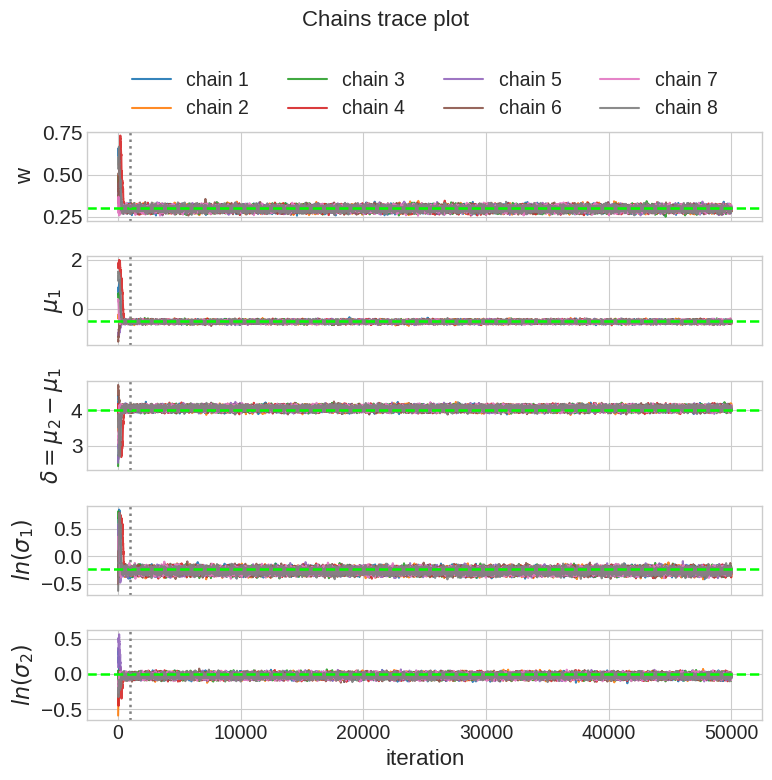

In [49]:
# scale 15% -> burnin = 9000
# scale 10% -> burnin = 1000
filename = "ensemble_trace_plot_sigmaT90_10"
fig, axes = plot_trace_chains(chains, filename, theta_sim, burnin=1000, save=True, outdir=outdir)
plt.show()

In [50]:
burnin = 1000
chains_new = chains[:,1000:,:]
chains_new.shape

(8, 49000, 5)

La threshold viene scelta guardando a quale valore di autocorrelazione corrisponde al parametro più lento (autocorrelazione più alta) a lag 25 (valore scelto nella mcmc con singola catena nelle condizioni di dati generati e logT90 = 0)

In [51]:
thinned_list, per_param_lags, per_chain_lags = thin_chains_by_acf(
    chains_new, threshold=0.072, max_lag_search=2000
)

# lags in cui acf < threshold per ogni parametro e ogni catena
print("per-param lags:\n", per_param_lags)
# per ogni catena scelgo il parametro con il lag maggiore
print("per-chain steps:", per_chain_lags)

per-param lags:
 [[24 24 22 17 25]
 [24 23 19 21 23]
 [25 26 21 19 26]
 [24 25 20 21 27]
 [26 26 21 20 23]
 [24 29 24 21 27]
 [25 28 21 21 26]
 [25 24 20 21 30]]
per-chain steps: [25 24 26 27 26 29 28 30]


In [52]:
for i in range(chains_new.shape[0]):
    print(f'chain {i+1} shape = {thinned_list[i].shape}')

chain 1 shape = (1960, 5)
chain 2 shape = (2042, 5)
chain 3 shape = (1885, 5)
chain 4 shape = (1815, 5)
chain 5 shape = (1885, 5)
chain 6 shape = (1690, 5)
chain 7 shape = (1750, 5)
chain 8 shape = (1634, 5)


Visto che dopo il thinning i valri sono indipendenti tra loro posso concatenare le 8 catene

In [53]:
# thinned_chains_list: lista di array (n_kept_k, d) — output della tua funzione
samples_final = np.concatenate([c for c in thinned_list], axis=0)  # shape (N_total, d)
samples_final.shape

(14661, 5)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:297: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0.06)
/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(pdf_path, dpi=300, bbox_inches='tight', pad_inches=0.06)


Saved: ../figure/generated_data_sigmaT90/marginal_distribution_mcmc_ensemble_sigmaT90.png (PNG 300 dpi) and ../figure/generated_data_sigmaT90/marginal_distribution_mcmc_ensemble_sigmaT90.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


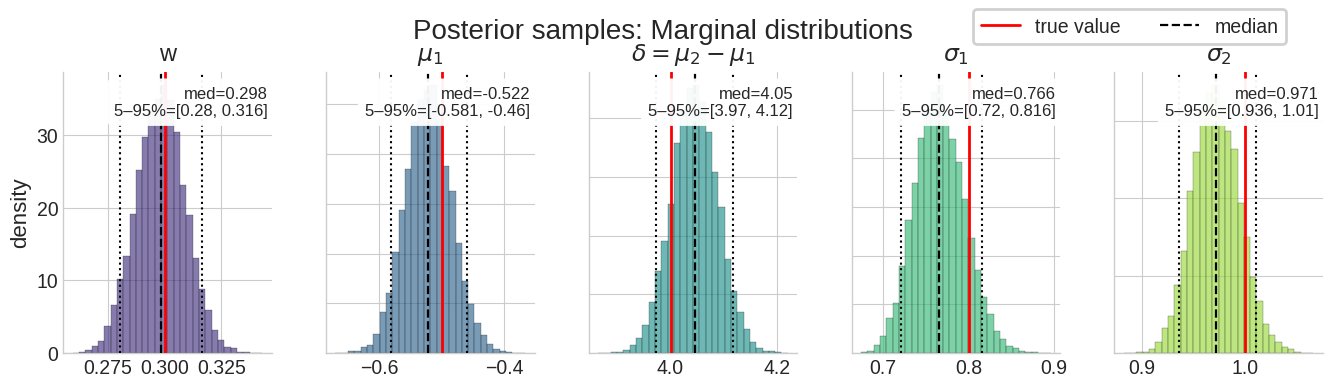

In [54]:
filename = 'marginal_distribution_mcmc_ensemble_sigmaT90'
fig2, axes2 = plot_marginal_distributions(samples_final, filename, theta_sim, sigma_scale='linear', outdir=outdir)

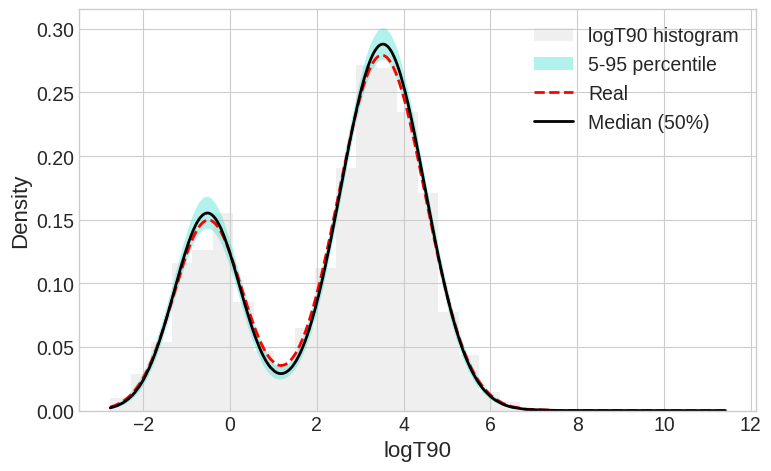

In [55]:
filename = 'distribution_mcmc_ensemble_sigmaT90'
fig4, axes4 = plot_distribution(logT90, samples_final, filename, theta_true=theta_sim, outdir=outdir)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:750: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


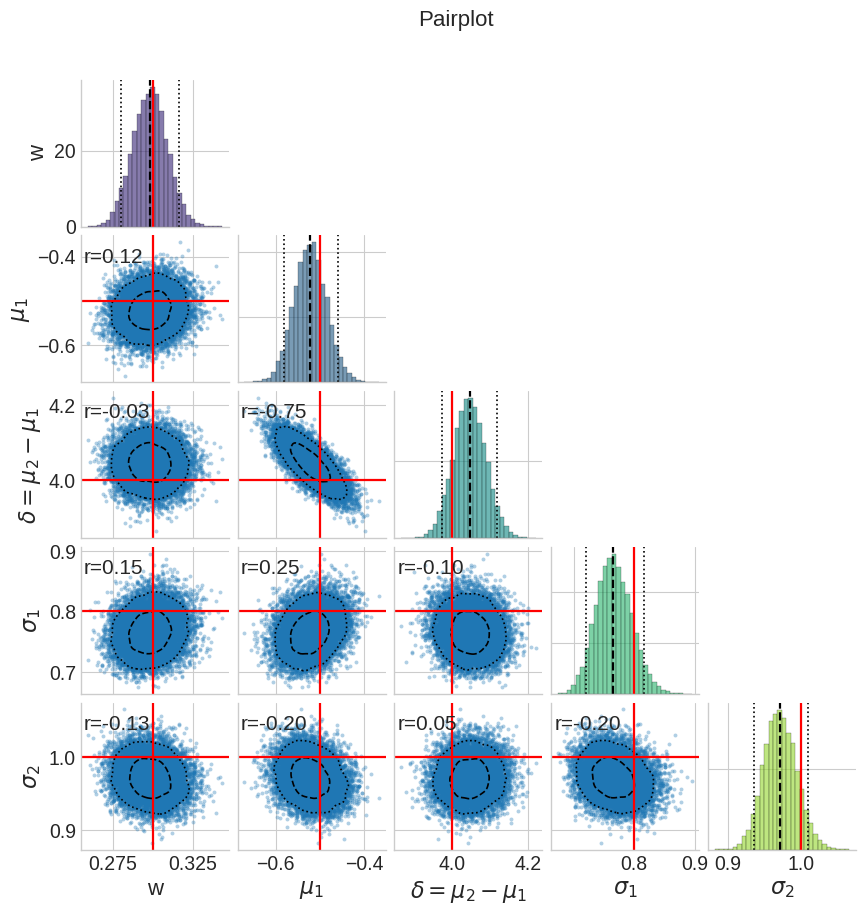

In [56]:
filename = 'Pairplot_ensemble_sigmaT90'
fig5, axes5 = pairplot(samples_final, filename, theta_sim, save=True, sigma_scale='linear', outdir=outdir)

In [57]:
# trasformazione
sigma1_samples = np.exp(samples_final[:,3])
sigma2_samples = np.exp(samples_final[:,4])

samples_transformed = samples_final.copy()
samples_transformed[:,3] = sigma1_samples
samples_transformed[:,4] = sigma2_samples

In [58]:
lns1, lns2 = samples_final[:,3:].T
w, mu1, delta, s1, s2 = samples_transformed.T
mu2 = mu1 + delta

scale1 = np.exp(mu1)
scale2 = np.exp(mu2)
mean1 = np.exp(mu1 + 0.5 * s1**2)
mean2 = np.exp(mu2 + 0.5 * s2**2)
sd1 = np.sqrt((np.exp(s1**2)-1) * np.exp(2*mu1 + s1**2))
sd2 = np.sqrt((np.exp(s2**2)-1) * np.exp(2*mu2 + s2**2))

def pctls(a):
    p = np.percentile(a, [5,16,50,84,95])
    mean  = np.mean(a)
    sigma = np.std(a, ddof=1)
    # median, +err, -err, +err90, -err90, sigma, mean
    return p[2], p[3]-p[2], p[2]-p[1], p[4]-p[2], p[2]-p[0], sigma, mean  

print("Parametri mcmc:")
for name, param in [('w',w),('mu1',mu1),('delta',delta),('mu2',mu2),
                    ('lns1', lns1),('lns2', lns2),('s1',s1),('s2',s2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f}  ({mean:.3f}±{sigma:.3f})    [{med-down90:.3f}, {med+up90:.3f}]  (90%)")

print("\nParametri in secondi:")
for name, param in [('median1',scale1),('median2',scale2),('mean1',mean1),('mean2',mean2),('sd1',sd1),('sd2',sd2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f} s  ({mean:.3f}±{sigma:.3f})   [{med-down90:.3f}, {med+up90:.3f}] s (90%)")

Parametri mcmc:
w: 0.298 +0.011 -0.011  (0.298±0.011)    [0.280, 0.316]  (90%)
mu1: -0.522 +0.037 -0.037  (-0.522±0.037)    [-0.581, -0.460]  (90%)
delta: 4.045 +0.043 -0.043  (4.045±0.044)    [3.974, 4.117]  (90%)
mu2: 3.524 +0.029 -0.029  (3.524±0.029)    [3.476, 3.572]  (90%)
lns1: -0.267 +0.039 -0.037  (-0.267±0.038)    [-0.328, -0.203]  (90%)
lns2: -0.029 +0.024 -0.023  (-0.029±0.023)    [-0.066, 0.010]  (90%)
s1: 0.766 +0.030 -0.028  (0.767±0.029)    [0.720, 0.816]  (90%)
s2: 0.971 +0.023 -0.022  (0.972±0.023)    [0.936, 1.010]  (90%)

Parametri in secondi:
median1: 0.593 +0.022 -0.021 s  (0.594±0.022)   [0.559, 0.631] s (90%)
median2: 33.909 +0.987 -0.965 s  (33.924±0.985)   [32.328, 35.583] s (90%)
mean1: 0.796 +0.039 -0.036 s  (0.798±0.038)   [0.738, 0.864] s (90%)
mean2: 54.379 +1.824 -1.736 s  (54.433±1.807)   [51.568, 57.491] s (90%)
sd1: 0.710 +0.069 -0.059 s  (0.715±0.065)   [0.618, 0.828] s (90%)
sd2: 68.104 +4.368 -3.862 s  (68.342±4.141)   [61.979, 75.486] s (90%)


## Real Data - sigma_logT90

In [87]:
LOAD = 0
outdir = '../figure/real_data_sigmaT90'

rng = np.random.default_rng(1234)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

# define the prior bounds
bounds = [
    [0.0, 1.0],     # w
    [-4, 7],        # mu1 (ln s)
    [0.0, 10.0],    # delta = mu2 - mu1
    [np.log(0.1), np.log(6.0)],    # ln(sigma1) 
    [np.log(0.1), np.log(6.0)]     # ln(sigma2)
]

if LOAD == 0:
    theta_center = init_theta_from_data(logT90, bounds)  
    
    # la cov stimata 
    covariance = np.array(
        ([ 0.00035431,  0.0018177,  -0.00129226,  0.00081391, -0.00039666],
         [ 0.0018177,   0.01617827, -0.01265535,  0.00607794, -0.00251953],
         [-0.00129226, -0.01265535,  0.01099872, -0.00445123,  0.00160026],
         [ 0.00081391,  0.00607794, -0.00445123,  0.0039254,  -0.00114485],
         [-0.00039666, -0.00251953,  0.00160026, -0.00114485,  0.00108923]))
    res = run_ensemble_chains(theta_center, logT90, bounds, rng=rng,
                              n_chains=8, n_steps=50000, cov_prop=covariance,
                              sigma_logT90=sigma_logT90, scale=0.1, verbose=True)
    
    # access:
    theta0s = res['theta0s']      # shape (8,5)
    chains  = res['chains']       # list of 8 arrays (n_steps,5)
    chains  = np.stack(chains)    # array 3D (n_chains,n_steps,5)
    accs    = res['acc_rates']    # list of 8 empirical acceptance rates

    np.savez_compressed("../chains/chains_stack_real_sigmaT90_10.npz", chains=chains, theta0s=theta0s, acc_rates=accs)
    
else:
    data = np.load("../chains/chains_stack_real_sigmaT90_10.npz")
    theta0s = data['theta0s']      # shape (8,5)
    chains  = data['chains']       # array 3D (n_chains,n_steps,5)
    accs    = data['acc_rates']

Starting chain 1/8, theta0 = [0.33961632 1.03520978 3.6822768  0.06248756 0.35364651]
iteration 0: acceptance 1.0
iteration 2500: acceptance 0.32506997201119553
iteration 5000: acceptance 0.32213557288542294
iteration 7500: acceptance 0.3252899613384882
iteration 10000: acceptance 0.32226777322267774
iteration 12500: acceptance 0.32405407567394606
iteration 15000: acceptance 0.3201786547563496
iteration 17500: acceptance 0.3189532026741329
iteration 20000: acceptance 0.3182840857957102
iteration 22500: acceptance 0.3175858850717746
iteration 25000: acceptance 0.3172273109075637
iteration 27500: acceptance 0.31693392967528455
iteration 30000: acceptance 0.3177560747975067
iteration 32500: acceptance 0.31719024030029846
iteration 35000: acceptance 0.31850518556612667
iteration 37500: acceptance 0.3183915095597451
iteration 40000: acceptance 0.3174420639484013
iteration 42500: acceptance 0.31869838356744545
iteration 45000: acceptance 0.31848181151529964
iteration 47500: acceptance 0.3180

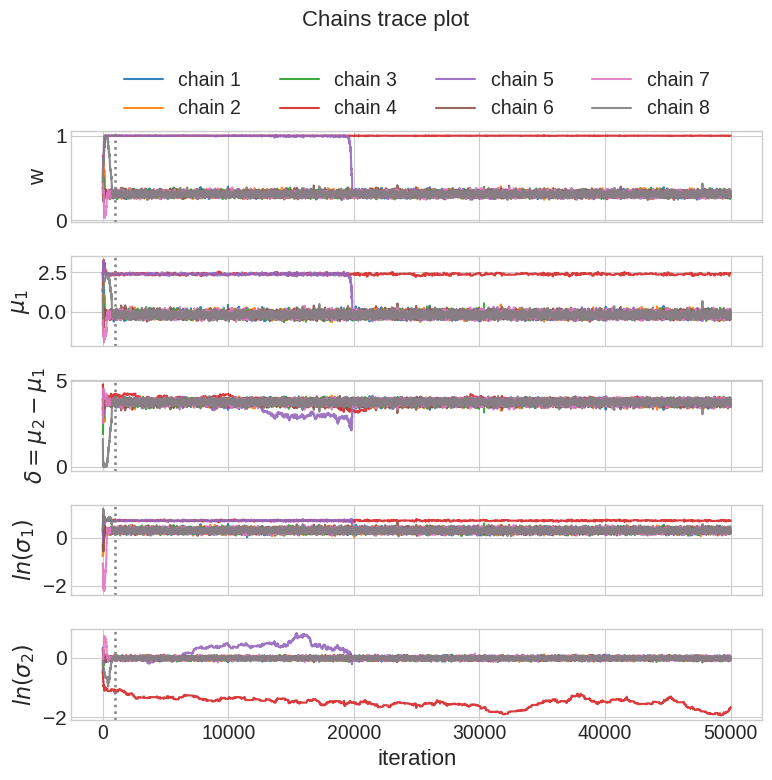

In [88]:
filename = "ensemble_trace_plot_real_sigmaT90_10"
fig, axes = plot_trace_chains(chains, filename, burnin=1000, save=True, outdir=outdir)
plt.show()

In [89]:
# Taglio le catene 4 e 5
chains_cut = chains.copy()
chains_cut = np.delete(chains_cut, [3,4], axis=0)
chains_cut.shape

(6, 50000, 5)

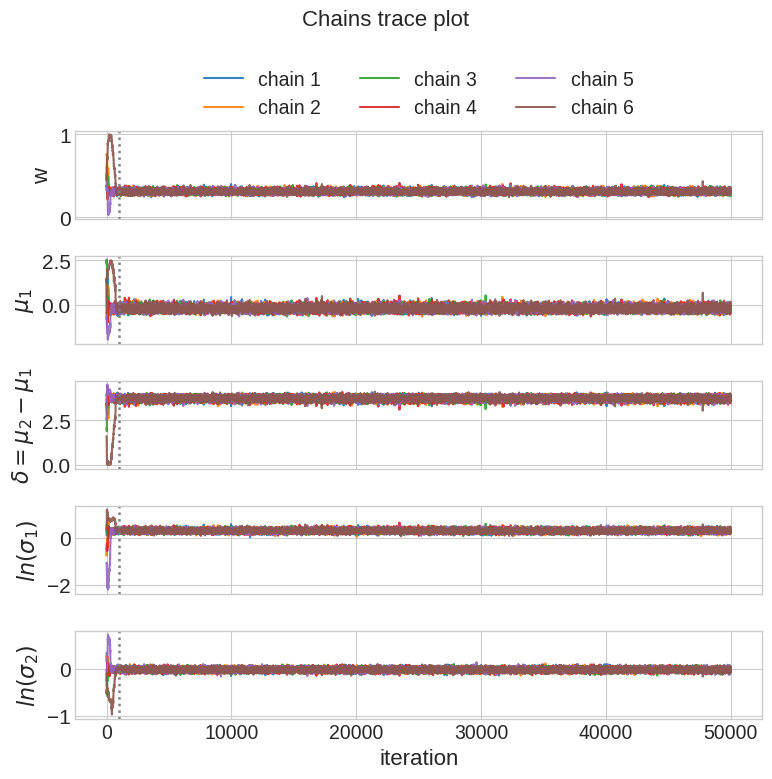

In [90]:
filename = "ensemble_trace_plot_real_sigmaT90_10_cut"
fig, axes = plot_trace_chains(chains_cut, filename, burnin=1000, save=True, outdir=outdir)
plt.show()

In [91]:
burnin = 1000
chains_new = chains_cut[:,burnin:,:]
chains_new.shape

(6, 49000, 5)

La threshold viene scelta guardando a quale valore di autocorrelazione corrisponde al parametro più lento (autocorrelazione più alta) a lag 25 (valore scelto nella mcmc con singola catena nelle condizioni di dati generati e logT90 = 0)

In [92]:
thinned_list, per_param_lags, per_chain_lags = thin_chains_by_acf(
    chains_new, threshold=0.048, max_lag_search=2000
)

# lags in cui acf < threshold per ogni parametro e ogni catena
print("per-param lags:\n", per_param_lags)
# per ogni catena scelgo il parametro con il lag maggiore
print("per-chain steps:", per_chain_lags)

per-param lags:
 [[29 30 30 27 26]
 [26 24 24 29 25]
 [28 25 24 26 25]
 [26 26 25 26 24]
 [30 30 28 26 28]
 [27 27 27 26 25]]
per-chain steps: [30 29 28 26 30 27]


In [93]:
for i in range(chains_new.shape[0]):
    print(f'chain {i+1} shape = {thinned_list[i].shape}')

chain 1 shape = (1634, 5)
chain 2 shape = (1690, 5)
chain 3 shape = (1750, 5)
chain 4 shape = (1885, 5)
chain 5 shape = (1634, 5)
chain 6 shape = (1815, 5)


Visto che dopo il thinning i valri sono indipendenti tra loro posso concatenare le 8 catene

In [94]:
# thinned_chains_list: lista di array (n_kept_k, d) — output della tua funzione
samples_final = np.concatenate([c for c in thinned_list], axis=0)  # shape (N_total, d)
samples_final.shape

(10408, 5)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:297: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0.06)
/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(pdf_path, dpi=300, bbox_inches='tight', pad_inches=0.06)


Saved: ../figure/real_data_sigmaT90/marginal_distribution_mcmc_ensemble_real_sigmaT90.png (PNG 300 dpi) and ../figure/real_data_sigmaT90/marginal_distribution_mcmc_ensemble_real_sigmaT90.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


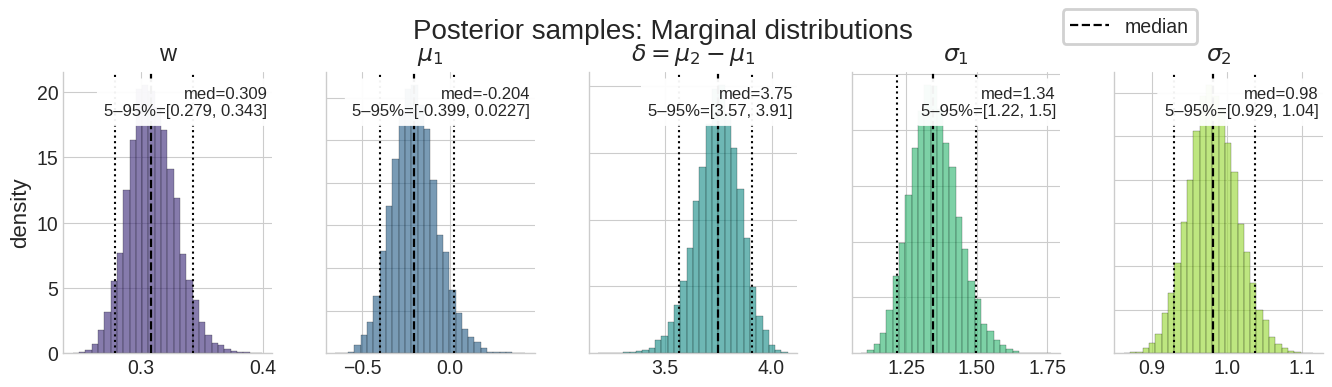

In [95]:
filename = 'marginal_distribution_mcmc_ensemble_real_sigmaT90'
fig2, axes2 = plot_marginal_distributions(samples_final, filename, sigma_scale='linear', outdir=outdir)

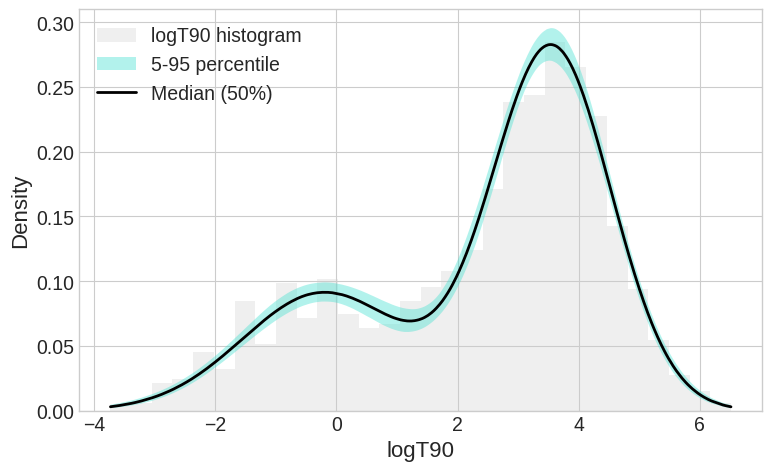

In [96]:
filename = 'distribution_mcmc_ensemble_real_sigmaT90'
fig4, axes4 = plot_distribution(logT90, samples_final, filename, outdir=outdir)

/home/leo/Desktop/Bayesian_probability/codes/mcmc_plots.py:750: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


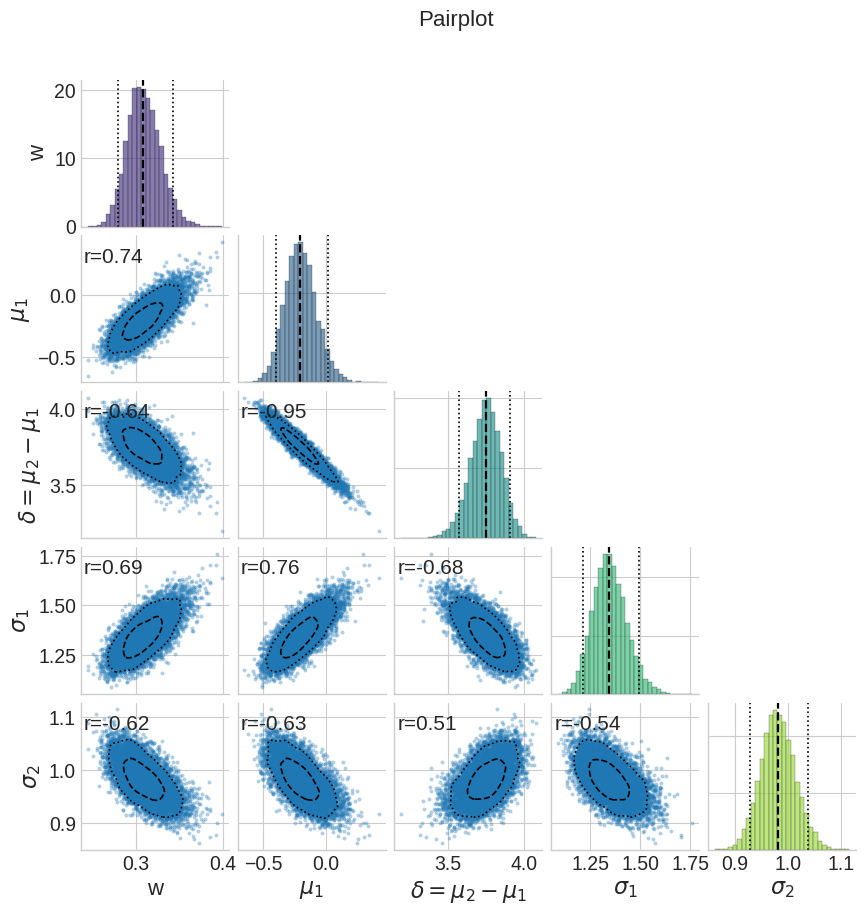

In [97]:
filename = 'Pairplot_ensemble_real_sigmaT90'
fig5, axes5 = pairplot(samples_final, filename, save=True, sigma_scale='linear', outdir=outdir)

In [98]:
# trasformazione
sigma1_samples = np.exp(samples_final[:,3])
sigma2_samples = np.exp(samples_final[:,4])

samples_transformed = samples_final.copy()
samples_transformed[:,3] = sigma1_samples
samples_transformed[:,4] = sigma2_samples

In [99]:
lns1, lns2 = samples_final[:,3:].T
w, mu1, delta, s1, s2 = samples_transformed.T
mu2 = mu1 + delta

scale1 = np.exp(mu1)
scale2 = np.exp(mu2)
mean1 = np.exp(mu1 + 0.5 * s1**2)
mean2 = np.exp(mu2 + 0.5 * s2**2)
sd1 = np.sqrt((np.exp(s1**2)-1) * np.exp(2*mu1 + s1**2))
sd2 = np.sqrt((np.exp(s2**2)-1) * np.exp(2*mu2 + s2**2))

def pctls(a):
    p = np.percentile(a, [5,16,50,84,95])
    mean  = np.mean(a)
    sigma = np.std(a, ddof=1)
    # median, +err, -err, +err90, -err90, sigma, mean
    return p[2], p[3]-p[2], p[2]-p[1], p[4]-p[2], p[2]-p[0], sigma, mean  

print("Parametri mcmc:")
for name, param in [('w',w),('mu1',mu1),('delta',delta),('mu2',mu2),
                    ('lns1', lns1),('lns2', lns2),('s1',s1),('s2',s2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f}  ({mean:.3f}±{sigma:.3f})    [{med-down90:.3f}, {med+up90:.3f}]  (90%)")

print("\nParametri in secondi:")
for name, param in [('median1',scale1),('median2',scale2),('mean1',mean1),('mean2',mean2),('sd1',sd1),('sd2',sd2)]:
    med, up68, down68, up90, down90, sigma, mean = pctls(param)
    print(f"{name}: {med:.3f} +{up68:.3f} -{down68:.3f} s  ({mean:.3f}±{sigma:.3f})   [{med-down90:.3f}, {med+up90:.3f}] s (90%)")

Parametri mcmc:
w: 0.309 +0.020 -0.018  (0.310±0.019)    [0.279, 0.343]  (90%)
mu1: -0.204 +0.129 -0.122  (-0.199±0.128)    [-0.399, 0.023]  (90%)
delta: 3.751 +0.098 -0.105  (3.747±0.103)    [3.569, 3.909]  (90%)
mu2: 3.548 +0.045 -0.046  (3.548±0.045)    [3.474, 3.622]  (90%)
lns1: 0.296 +0.064 -0.061  (0.298±0.062)    [0.195, 0.403]  (90%)
lns2: -0.020 +0.033 -0.032  (-0.019±0.033)    [-0.074, 0.036]  (90%)
s1: 1.345 +0.088 -0.079  (1.349±0.085)    [1.215, 1.496]  (90%)
s2: 0.980 +0.033 -0.031  (0.981±0.033)    [0.929, 1.037]  (90%)

Parametri in secondi:
median1: 0.816 +0.112 -0.093 s  (0.827±0.109)   [0.671, 1.023] s (90%)
median2: 34.760 +1.608 -1.554 s  (34.795±1.575)   [32.270, 37.420] s (90%)
mean1: 2.014 +0.539 -0.381 s  (2.100±0.511)   [1.441, 3.051] s (90%)
mean2: 56.315 +1.943 -1.964 s  (56.328±1.973)   [53.104, 59.595] s (90%)
sd1: 4.547 +2.063 -1.271 s  (4.984±2.014)   [2.678, 8.720] s (90%)
sd2: 71.487 +4.963 -4.304 s  (71.792±4.690)   [64.564, 79.812] s (90%)
